In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS'

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sys
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [3]:
inflow_df = pd.read_csv('../../dataset/reservoir_dataset_engg.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 9)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4


In [4]:
rainfall_departure_df = pd.read_csv('../../dataset/Rainfall 2010-2020/rainfall_departure_dataset.csv')
print(rainfall_departure_df.shape)
rainfall_departure_df.head()

(4004, 6)


,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON
0,BAGALKOTE,0.0,2008,1,-100.0,WINTER
1,BELLARY,0.0,2008,1,-100.0,WINTER
2,KOLAR,0.0,2008,1,-100.0,WINTER
3,GULBARGA,0.0,2008,1,-100.0,WINTER
4,BANGALORE URBAN,0.1,2008,1,-88.0,WINTER


### Dataset Transformation

In [5]:
inflow_df = inflow_df.drop(columns=['RESERVOIR', 'PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'OUTFLOW_CUECS', 'DAY'])
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE
0,2029.0,2011,1,1
1,3084.0,2011,1,2
2,2776.0,2011,1,3
3,2311.0,2011,1,4
4,1847.0,2011,1,5


In [6]:
rainfall_departure_df = rainfall_departure_df[rainfall_departure_df['DISTRICTS'] == 'KODAGU']
rainfall_departure_df['YEAR'] = rainfall_departure_df['YEAR'].astype(float)
rainfall_departure_df['MONTH'] = rainfall_departure_df['MONTH'].astype(float)
rainfall_departure_df.shape

(156, 6)

### Dataset and DataLoader

In [7]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
date_le = LabelEncoder().fit(inflow_df['DATE'].unique())
season_le = LabelEncoder().fit(rainfall_departure_df['SEASON'].unique())

In [8]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020]
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020]

train_inflow_df.shape, val_inflow_df.shape

((2944, 4), (330, 4))

In [9]:
class InflowDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        inflow, year, month, date = self.df.iloc[index].values
        _, monthly_rainfall, year, month, departure, season = rainfall_departure_df[(rainfall_departure_df['YEAR'] == year) & (rainfall_departure_df['MONTH'] == month)].values[0]
        prev_rainfall_departure_df = rainfall_departure_df[(rainfall_departure_df['YEAR'] < year) & (rainfall_departure_df['MONTH'] == month)].sort_values('YEAR', ascending=False).head(3)
        prev_avg_rainfall = np.matmul(prev_rainfall_departure_df['RAINFALL'], [[0.4], [0.3], [0.3]])[0]
        prev_avg_departure = np.matmul(prev_rainfall_departure_df['DEPARTURE'], [[0.4], [0.3], [0.3]])[0]
        
        month_transformed = month_le.transform([month])
        date_transformed = date_le.transform([date])
        season_transformed = season_le.transform([season])

        return (torch.tensor(month_transformed[0]), \
                torch.tensor(date_transformed[0]), \
                torch.tensor(season_transformed[0]), \
                torch.FloatTensor([prev_avg_rainfall, prev_avg_departure])), torch.FloatTensor([inflow])
    
    def __len__(self):
        return self.df.shape[0]

In [10]:
train_ds = InflowDataset(train_inflow_df)
val_ds = InflowDataset(val_inflow_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=2)

### Model

In [11]:
class SimpleMLP(nn.Module):
    def __init__(self, nmonth, ndate, nseason):
        super().__init__()
        self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=32)
        self.date_emb = nn.Embedding(num_embeddings=ndate, embedding_dim=32)
        self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=32)
        self.prev_data_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.SELU(),
            nn.Linear(in_features=16, out_features=32),
            nn.SELU()
        )

        self.conv_1 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.res_layer_1 = nn.Sequential(
            nn.BatchNorm2d(num_features=12),
            nn.SELU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=12),
            nn.SELU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        )
        self.hidden_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=6, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        self.res_layer_2 = nn.Sequential(
            nn.BatchNorm2d(num_features=6),
            nn.SELU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=6),
            nn.SELU(),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        )
        self.hidden_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=1, kernel_size=3, stride=2, padding=1),
            nn.SELU()
        )
        
        self.inflow_layer = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.SELU(),
            nn.Linear(in_features=32, out_features=1),
            nn.ReLU()
        )
    
    def forward(self, x_month, x_date, x_season, x_prev_data):
        bs = x_month.shape[0]

        month_out = self.month_emb(x_month)
        date_out = self.date_emb(x_date)
        season_out = self.season_emb(x_season)
        prev_data_out = self.prev_data_layer(x_prev_data)

        month_date = torch.bmm(month_out.view(bs, -1, 1), date_out.view(bs, 1, -1))
        month_season = torch.bmm(month_out.view(bs, -1, 1), season_out.view(bs, 1, -1))
        month_prev_data = torch.bmm(month_out.view(bs, -1, 1), prev_data_out.view(bs, 1, -1))
        date_season = torch.bmm(date_out.view(bs, -1, 1), season_out.view(bs, 1, -1))
        date_prev_date = torch.bmm(date_out.view(bs, -1, 1), prev_data_out.view(bs, 1, -1))
        season_prev_date = torch.bmm(season_out.view(bs, -1, 1), prev_data_out.view(bs, 1, -1))

        x = torch.stack([month_date, month_season, month_prev_data, date_season, date_prev_date, season_prev_date], axis=1)
        conv_out = self.conv_1(x)
        res_out_1 = self.res_layer_1(conv_out) + conv_out
        hidden_out_1 = self.hidden_layer_1(res_out_1)
        res_out_2 = self.res_layer_2(hidden_out_1) + hidden_out_1
        res_out_2 += hidden_out_1
        hidden_out_2 = self.hidden_layer_2(res_out_2)
        hidden_out_2 = hidden_out_2.view(bs, -1)
        
        inflow_out = self.inflow_layer(hidden_out_2)

        return inflow_out.view(bs)
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight)

### Training

In [12]:
def train(model, epochs, lr, save_best=False):
    opt = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(opt, patience=10, min_lr=1e-8)
    criterion = nn.MSELoss()

    best_val = float('inf')
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_month = xb[0].cuda()
            x_date = xb[1].cuda()
            x_season = xb[2].cuda()
            x_prev_data = xb[3].cuda()
            yb = yb.view(-1).cuda()

            y_hat = model(x_month, x_date, x_season, x_prev_data)
            loss = criterion(y_hat, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_month = xb[0].cuda()
                x_date = xb[1].cuda()
                x_season = xb[2].cuda()
                x_prev_data = xb[3].cuda()
                yb = yb.view(-1).cuda()

                y_hat = model(x_month, x_date, x_season, x_prev_data)
                loss = criterion(y_hat, yb)

                val_loss += loss.item()
                
        scheduler.step(train_loss)

        if scheduler._last_lr[0] <= 1e-06:
            break
        
        if save_best and best_val >= val_loss:
            torch.save(model.state_dict(), 'inflow_cnn_date_bestmodel.pth')
            best_val = val_loss
        print(f'Epoch - {epoch+1} | LR - {scheduler._last_lr[0]} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [13]:
model = SimpleMLP(len(month_le.classes_), len(date_le.classes_), len(season_le.classes_)).cuda()
model.weight_init()

In [14]:
train(model, epochs=5, lr=1e-02)

Epoch - 1 | LR - 0.01 | Train Loss - 40355366.91 | Val Loss - 22746679.93
Epoch - 2 | LR - 0.01 | Train Loss - 34749443.51 | Val Loss - 22632726.82
Epoch - 3 | LR - 0.01 | Train Loss - 35465244.84 | Val Loss - 20043649.39
Epoch - 4 | LR - 0.01 | Train Loss - 32184034.82 | Val Loss - 26833250.53
Epoch - 5 | LR - 0.01 | Train Loss - 31328122.47 | Val Loss - 16640897.46


In [15]:
train(model, epochs=200, lr=1e-03, save_best=True)

Epoch - 1 | LR - 0.001 | Train Loss - 27473966.52 | Val Loss - 17959227.49
Epoch - 2 | LR - 0.001 | Train Loss - 26689216.27 | Val Loss - 16596030.96
Epoch - 3 | LR - 0.001 | Train Loss - 26135716.62 | Val Loss - 15465537.7
Epoch - 4 | LR - 0.001 | Train Loss - 25625395.42 | Val Loss - 15324824.27
Epoch - 5 | LR - 0.001 | Train Loss - 25103589.18 | Val Loss - 17006656.78
Epoch - 6 | LR - 0.001 | Train Loss - 24950962.2 | Val Loss - 15220015.36
Epoch - 7 | LR - 0.001 | Train Loss - 25177316.59 | Val Loss - 14347960.89
Epoch - 8 | LR - 0.001 | Train Loss - 24660980.62 | Val Loss - 14140896.43
Epoch - 9 | LR - 0.001 | Train Loss - 24409748.73 | Val Loss - 14784738.73
Epoch - 10 | LR - 0.001 | Train Loss - 24274249.64 | Val Loss - 18728374.31
Epoch - 11 | LR - 0.001 | Train Loss - 24615225.43 | Val Loss - 15507173.08
Epoch - 12 | LR - 0.001 | Train Loss - 23858834.75 | Val Loss - 15652818.48
Epoch - 13 | LR - 0.001 | Train Loss - 23632272.77 | Val Loss - 19126288.54
Epoch - 14 | LR - 0.001

In [ ]:
model.load_state_dict(torch.load('inflow_cnn_date_bestmodel.pth'))
model.eval()

SimpleMLP(
  (month_emb): Embedding(12, 32)
  (date_emb): Embedding(31, 32)
  (season_emb): Embedding(3, 32)
  (prev_data_layer): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): SELU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): SELU()
  )
  (conv_1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_layer_1): Sequential(
    (0): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): SELU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SELU()
    (5): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (hidden_layer_1): Sequential(
    (0): Conv2d(12, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (res_layer_2): Sequential(
    (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affin

### Prediction on Validation Dataset

In [16]:
mod_df = []
for idx, row in inflow_df.sort_values(['YEAR', 'MONTH', 'DATE']).iterrows():
    inflow = row['INFLOW_CUSECS']
    year = row['YEAR']
    month = row['MONTH']
    date = row['DATE']

    _, monthly_rainfall, year, month, departure, season = rainfall_departure_df[(rainfall_departure_df['YEAR'] == year) & (rainfall_departure_df['MONTH'] == month)].values[0]
    prev_rainfall_departure_df = rainfall_departure_df[(rainfall_departure_df['YEAR'] < year) & (rainfall_departure_df['MONTH'] == month)].sort_values('YEAR', ascending=False).head(3)
    prev_avg_rainfall = np.matmul(prev_rainfall_departure_df['RAINFALL'], [[0.5], [0.3], [0.2]])[0]
    prev_avg_departure = np.matmul(prev_rainfall_departure_df['DEPARTURE'], [[0.5], [0.3], [0.2]])[0]

    mod_df.append([inflow, year, month, date, monthly_rainfall, departure, prev_avg_rainfall, prev_avg_departure, season])

mod_df = pd.DataFrame(mod_df, columns=['INFLOW_CUSECS', 'YEAR', 'MONTH', 'DATE', 'MONTHLY_RAINFALL', 'MONTHLY_DEPARTURE', 'PREV_AVG_RAINFALL', 'PREV_AVG_DEPARTURE', 'SEASON'])
mod_df

,INFLOW_CUSECS,YEAR,MONTH,DATE,MONTHLY_RAINFALL,MONTHLY_DEPARTURE,PREV_AVG_RAINFALL,PREV_AVG_DEPARTURE,SEASON
0,2029.0,2011.0,1.0,1.0,0.7,-80.0,6.20,44.0,WINTER
1,3084.0,2011.0,1.0,2.0,0.7,-80.0,6.20,44.0,WINTER
2,2776.0,2011.0,1.0,3.0,0.7,-80.0,6.20,44.0,WINTER
3,2311.0,2011.0,1.0,4.0,0.7,-80.0,6.20,44.0,WINTER
4,1847.0,2011.0,1.0,5.0,0.7,-80.0,6.20,44.0,WINTER
...,...,...,...,...,...,...,...,...,...
3269,3496.0,2020.0,12.0,12.0,9.9,-50.0,24.57,29.3,WINTER
3270,3197.0,2020.0,12.0,13.0,9.9,-50.0,24.57,29.3,WINTER
3271,3026.0,2020.0,12.0,14.0,9.9,-50.0,24.57,29.3,WINTER
3272,2530.0,2020.0,12.0,15.0,9.9,-50.0,24.57,29.3,WINTER


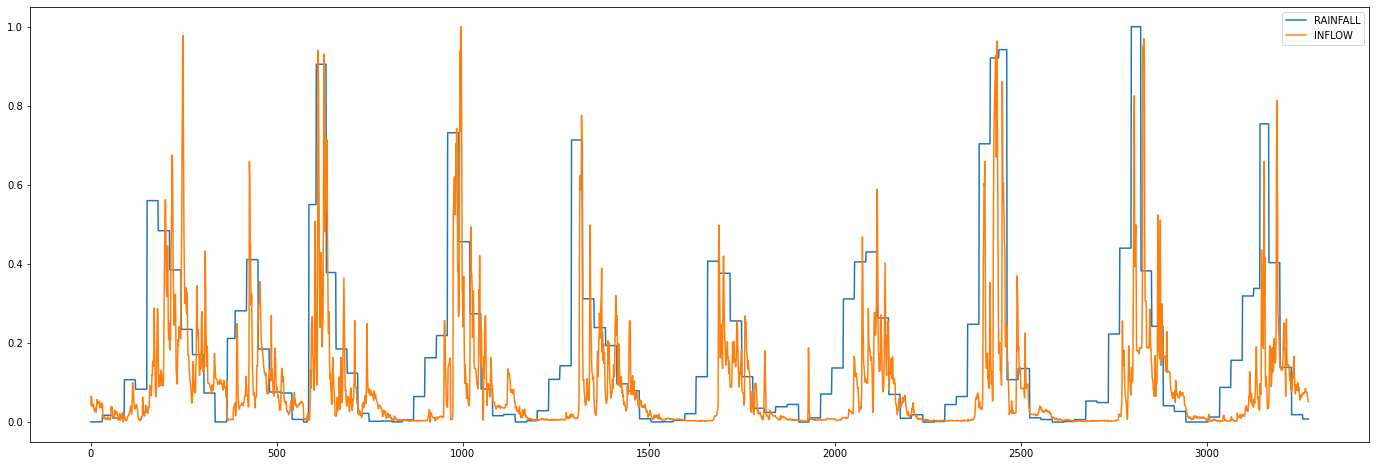

In [ ]:
# pred_2017 = mod_df[mod_df['YEAR'] == 2017].reset_index(drop=True)
# pred_2018 = mod_df[mod_df['YEAR'] == 2018].reset_index(drop=True)
# pred_2019 = mod_df[mod_df['YEAR'] == 2019].reset_index(drop=True)
# pred_2020 = mod_df[mod_df['YEAR'] == 2020].reset_index(drop=True)
plt.figure(figsize=(24, 8))
plt.plot(mod_df['MONTHLY_RAINFALL'] / mod_df['MONTHLY_RAINFALL'].max(), label='RAINFALL')
plt.plot(mod_df['INFLOW_CUSECS'] / mod_df['INFLOW_CUSECS'].max(), label='INFLOW')
plt.legend()
plt.show()

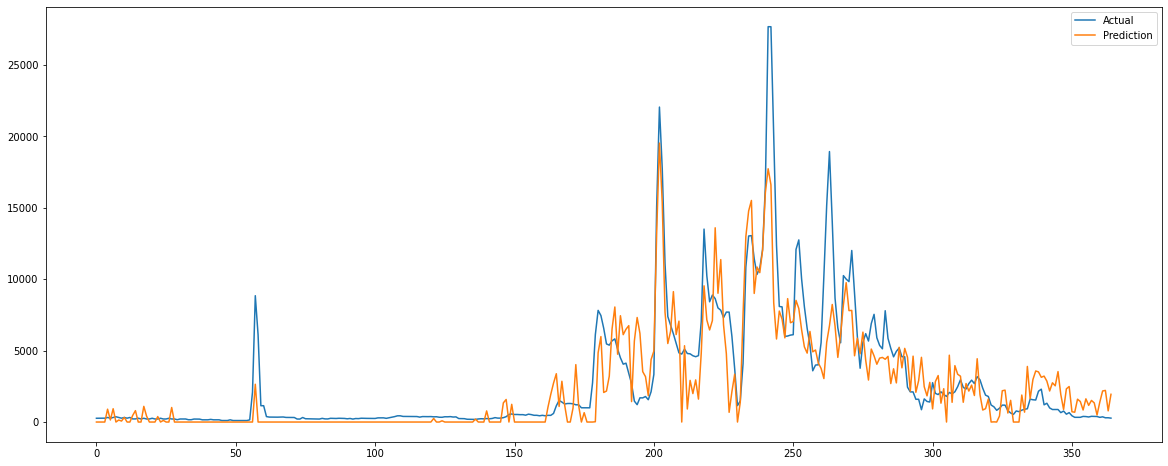

In [ ]:
pred = model_test_df[model_test_df['YEAR'] == 2017].reset_index(drop=True)
plt.figure(figsize=(20, 8))
plt.plot(pred['INFLOW_CUSECS'], label='Actual')
plt.plot(pred['Predicted_Inflow'], label='Prediction')
plt.legend()
plt.show()
# pred_2017 = mod_df[mod_df['YEAR'] == 2017].reset_index(drop=True)
# pred_2018 = mod_df[mod_df['YEAR'] == 2018].reset_index(drop=True)
# pred_2019 = mod_df[mod_df['YEAR'] == 2019].reset_index(drop=True)
# pred_2020 = mod_df[mod_df['YEAR'] == 2020].reset_index(drop=True)
# plt.figure(figsize=(24, 8))
# plt.plot(pred_2017['PREV_AVG_RAINFALL'], label='2017')
# plt.plot(pred_2018['PREV_AVG_RAINFALL'], label='2018')
# plt.plot(pred_2019['PREV_AVG_RAINFALL'], label='2019')
# plt.plot(pred_2020['PREV_AVG_RAINFALL'], label='2020')
# plt.legend()
# plt.show()

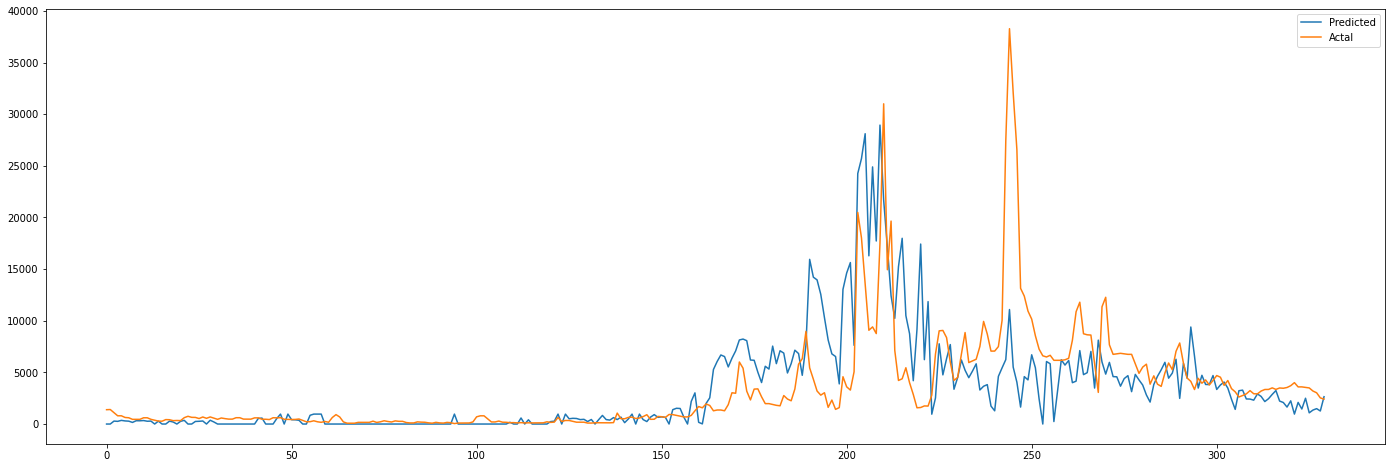

In [ ]:
y_actual_inflow, y_pred_inflow = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        x_month = xb[0].cuda()
        x_date = xb[1].cuda()
        x_season = xb[2].cuda()
        x_prev_data = xb[3].cuda()
        yb = yb.view(-1)

        y_hat = model(x_month, x_date, x_season, x_prev_data)

        y_actual_inflow += yb.data.tolist()
        y_pred_inflow += y_hat.cpu().data.tolist()

y_actual_inflow = np.array(y_actual_inflow).flatten()
y_pred_inflow = np.array(y_pred_inflow).flatten()

plt.figure(figsize=(24,8))
plt.plot(y_pred_inflow, label='Predicted')
plt.plot(y_actual_inflow, label='Actal')
plt.legend()
plt.show()

### Prediction on entire Dataset

In [ ]:
def pred(df):
    pred_ds = InflowDataset(df.copy())
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x_month = x[0].cuda()
            x_date = x[1].cuda()
            x_season = x[2].cuda()
            x_prev_data = x[3].cuda()
            y = y.view(-1)

            y_hat = model(x_month, x_date, x_season, x_prev_data)

    return y_hat.data.cpu().view(-1).tolist()

In [ ]:
model_test_df = inflow_df.sort_values(by=['YEAR', 'DATE']).copy()
model_test_df['Predicted_Inflow'] = pred(model_test_df)
model_test_df[:10]

,INFLOW_CUSECS,YEAR,MONTH,DATE,Predicted_Inflow
0,2029.0,2011,1,1,2473.032471
31,1987.0,2011,2,1,0.000000
59,635.0,2011,3,1,0.000000
90,587.0,2011,4,1,573.802063
120,1719.0,2011,5,1,533.258911
151,1306.0,2011,6,1,509.003296
181,7601.0,2011,7,1,10184.159180
212,8588.0,2011,8,1,8277.856445
243,18132.0,2011,9,1,10184.159180
273,2668.0,2011,10,1,5739.597168


In [ ]:
avg_daily_pred_inflow = model_test_df.groupby(['MONTH', 'DATE'])['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_test_df.groupby(['MONTH', 'DATE'])['INFLOW_CUSECS'].mean().values
avg_daily_actual_rainfall = rainfall_departure_df.groupby(['MONTH'])['RAINFALL'].mean().values

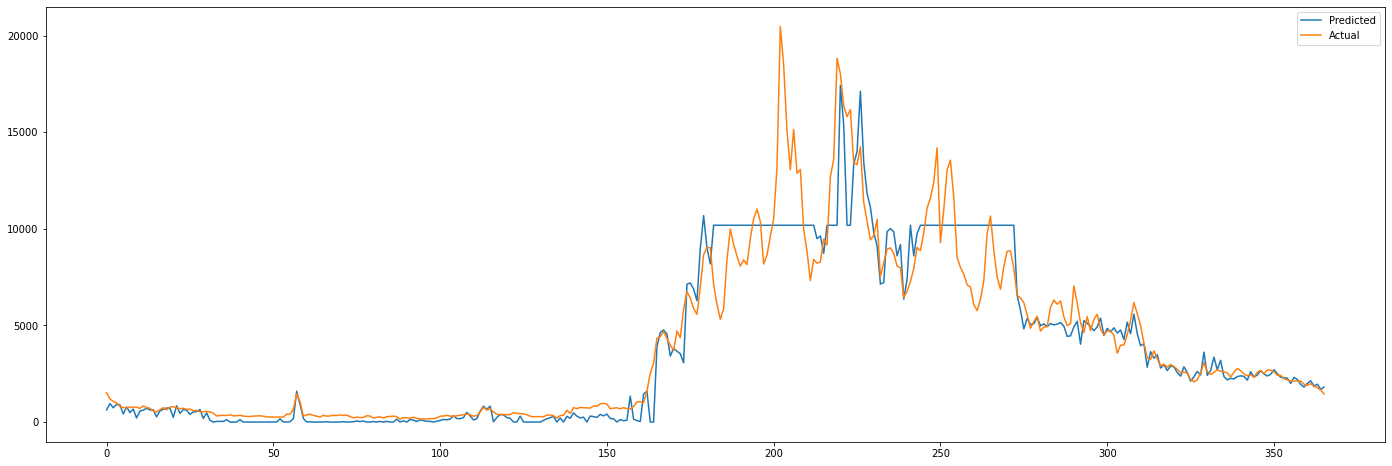

In [ ]:
plt.figure(figsize=(24, 8))
plt.plot(avg_daily_pred_inflow, label='Predicted')
plt.plot(avg_daily_actual_inflow, label='Actual')
plt.legend()
# ax2.plot(avg_daily_actual_rainfall, label='Actual')
plt.show()

In [ ]:
model_test_df.sort_values(by=['YEAR', 'MONTH', 'DATE'], inplace=True)

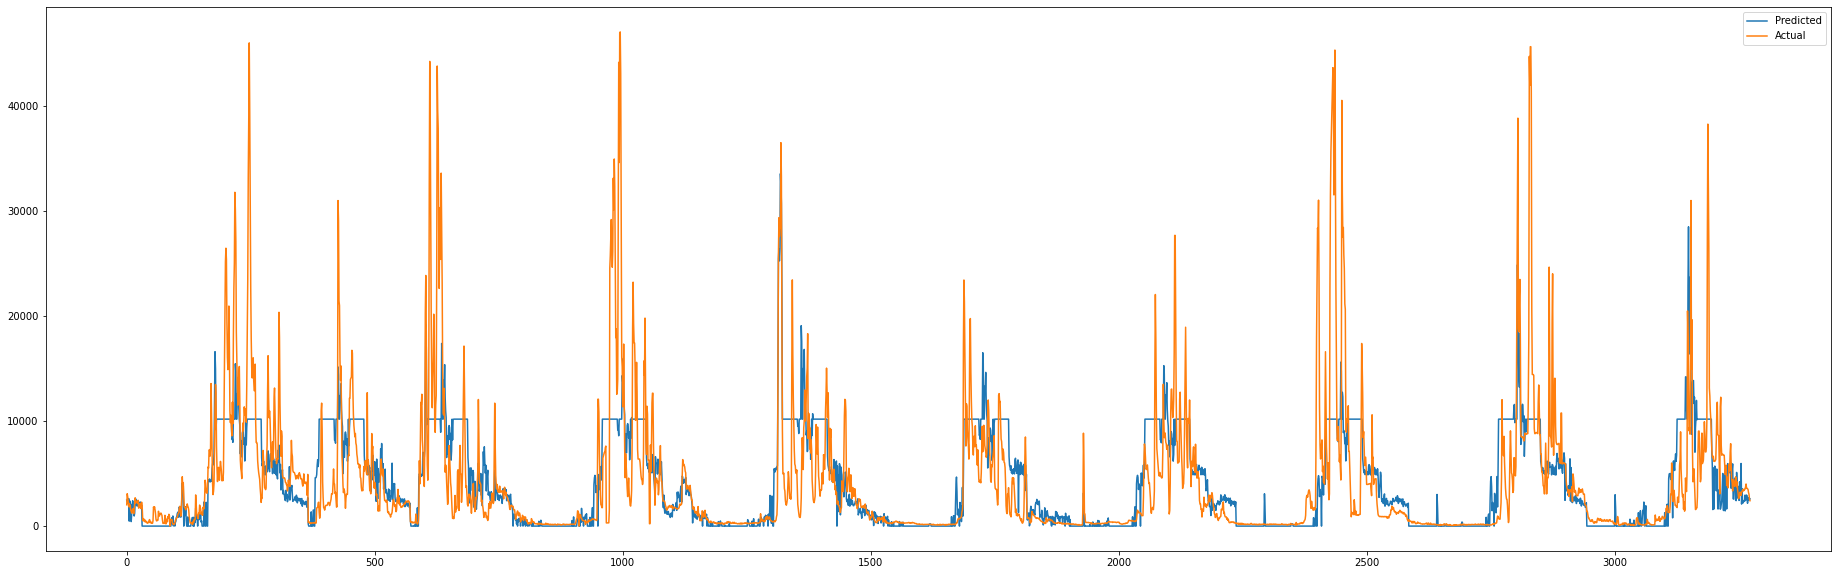

In [ ]:
plt.figure(figsize=(32, 10))
plt.plot(model_test_df['Predicted_Inflow'], label='Predicted')
plt.plot(model_test_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

In [ ]:
train_data_with_pred = model_test_df[model_test_df['YEAR'] < 2020]
val_data_with_pred = model_test_df[model_test_df['YEAR'] == 2020]
train_data_with_pred.shape, val_data_with_pred.shape

((2944, 5), (330, 5))

In [ ]:
((train_data_with_pred['INFLOW_CUSECS'] - train_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5

5110.672468272242

In [ ]:
((val_data_with_pred['INFLOW_CUSECS'] - val_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5

4277.037064528127

In [ ]:
# torch.save(model.state_dict(), 'inflow_rainfall_multihead_model.pth')